In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.models import resnet34

from dataset import CustomRotationDataset
from tqdm.notebook import tqdm_notebook as tqdm
from save_and_load import save, load
import torchvision.transforms as T
import random
from PIL import Image
import numpy as np

from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
import torchvision.models as models
from IPython.display import clear_output
from torchvision.transforms.functional import perspective

In [2]:
torch.manual_seed(42)

In [3]:
def gauss_noise_tensor(img):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)
    
    sigma = random.uniform(0, 1) * 0.3
    
    out = img + sigma * torch.randn_like(img)
    
    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out

In [4]:
#    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std

In [5]:
transform_shakal = transforms.Compose([
    transforms.ToTensor(),

    T.RandomPerspective(distortion_scale=random.uniform(0.1, 0.3), p=0.3),
    gauss_noise_tensor,
    T.GaussianBlur(kernel_size=(5, 9), sigma=(0.01, 1)),
    
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_norm = transforms.Compose([
    transforms.ToTensor(),

    T.RandomPerspective(distortion_scale=random.uniform(0.1, 0.3), p=0.2),

    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
train_dataset = CustomRotationDataset('./data224/train', transform_shakal=transform_shakal, transform_norm=transform_norm, shakal_prob=0.1)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomRotationDataset('./data224/test', transform_shakal=transform_shakal, transform_norm=transform_norm, shakal_prob=0.1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1)


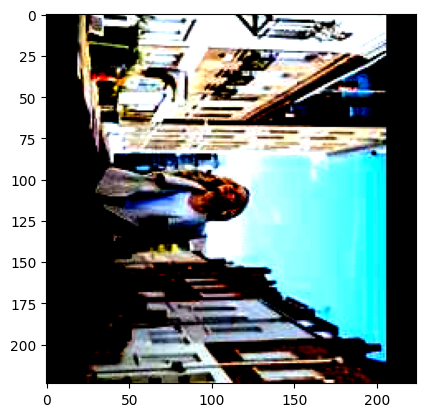

In [7]:
for i, l in train_loader:
    image = i[0].permute(1, 2, 0).numpy()  # Convert tensor to NumPy array and rearrange dimensions
    plt.imshow(image)
    print(l[0])
    break

In [8]:
from accelerate import Accelerator
accelerator = Accelerator()
device = accelerator.device

In [9]:
print(device)

cuda


In [10]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = True

n_inputs = model.fc.in_features

model.fc = nn.Sequential(nn.Linear(n_inputs, 1024),
                                nn.ReLU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(1024, 1024),
                                nn.ReLU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(1024, 2))

for name, child in model.named_children():
    for name2, params in child.named_parameters():
        params.requires_grad = True

model.to(device)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [12]:
def angle_loss(output, target):
    #print(output)
    #print(target)

    with torch.no_grad():
        output = torch.argmax(output, dim=1)
        #print(output)
        diff = torch.abs(target - output)
        #print(diff)
        #loss = torch.log( diff )
        #print(loss)
    res = torch.tensor(torch.mean(diff).item(), requires_grad=True)
    return res

In [13]:
def build_plot(test_loss_values, val_loss_values, val_acc_values, lr_values):
    plt.figure(figsize=(9, 9))

    plt.subplot(3, 2, 1)
    plt.plot(test_loss_values, label="train_loss")
    plt.plot(val_loss_values, label="val_loss")
    plt.legend()

    plt.subplot(3, 2, 2)
    plt.plot(val_acc_values, label="val_accuracy")
    plt.legend()

    plt.subplot(3, 2, 3)
    plt.plot(lr_values[-10:], label="lr")
    plt.legend()

    plt.show()

In [19]:
def train(model, train_loader, loss_fn, optimizer, n_epochs, device, threshold=0.3):
    model = model.to(device)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)

    print(f'Training started, batch per size = {42}')

    test_loss_values = []
    val_loss_values = []
    val_acc_values = []
    lr_values = []
    lr_dict = {}

    fpr_values = []
    tpr_values = []
    #roc_values = [0]

    for epoch in range(n_epochs):
        clear_output(wait=True)

        if epoch!=0: print(val_acc_values[-1])
      
        build_plot(test_loss_values, val_loss_values, val_acc_values, lr_values)

        running_loss = 0.0
        running_accuracy = 0.0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

        for i, (inputs, targets) in enumerate(pbar):
            optimizer.zero_grad()

            outputs = model(inputs)#.double()
            #loss1 = loss_fn(outputs, targets)
            #print(loss1)
            loss = loss_fn(outputs, targets)
            #print(loss)

            #loss = loss
            accelerator.backward(loss)
            optimizer.step()

            #print(loss)

            running_loss += loss.item()

            pbar.set_postfix(loss=loss.item())

        epoch_loss = running_loss/len(train_loader)
        print(running_loss)
        print(epoch_loss)
        test_loss_values.append(epoch_loss)

        val_accuracy, val_loss = test(model, test_loader, loss_fn, device)

        val_loss_values.append(val_loss)
        val_acc_values.append(val_accuracy)

        scheduler.step(val_loss)
        lr_values.append(optimizer.param_groups[0]['lr'])
        lr_dict[epoch] = optimizer.param_groups[0]['lr']

        if (epoch+1)%5==0: save(model, f'{epoch}', './resnet50')
    
    print(lr_dict)

In [20]:
def test(model, test_loader, loss_fn, device, threshold=0.3):
    model.eval()

    true_labels = []
    predicted_labels = []
    sick_labels = []
    test_loss = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            output = model(inputs)

            test_loss += loss_fn(output, targets).item()
            predicted = np.argmax(output.cpu(), axis=1)
            probabilities = torch.nn.Softmax(dim=1)(output)

            sick_labels.append(probabilities[:, 1].cpu())
            true_labels.append(targets.cpu())
            predicted_labels.append(predicted.cpu())
    
    true_labels = np.concatenate(true_labels, axis=0)
    predicted_labels = np.concatenate(predicted_labels, axis=0)
    sick_labels = np.concatenate(sick_labels, axis=0)

    #fpr, tpr, thresholds = roc_curve(true_labels, sick_labels)
    #roc_auc = auc(fpr, tpr) 

    test_accuracy = accuracy_score(true_labels, predicted_labels)
    test_loss /= len(test_loader)

    return test_accuracy, test_loss

In [21]:
model, optimizer, train_loader, test_loader = accelerator.prepare(
    model, optimizer, train_loader, test_loader
)

0.9888157894736842


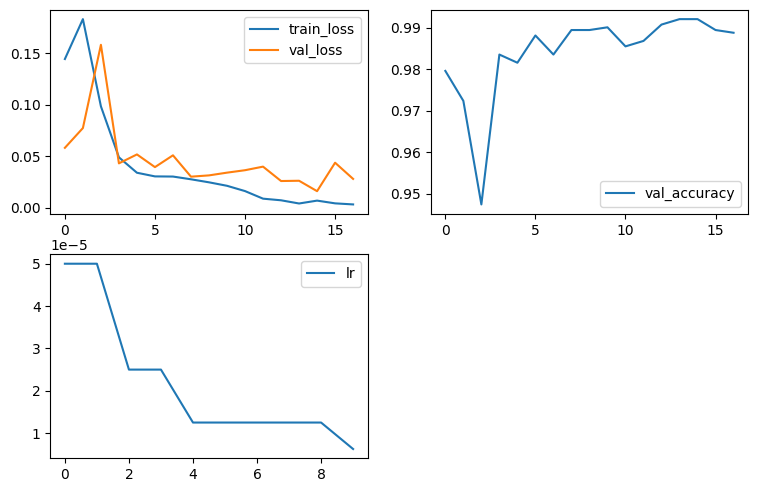

Epoch 18:   0%|          | 0/270 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
train(model, train_loader, loss_fn, optimizer, 50, device)

In [25]:
dic = torch.load('./resnet50/models/14/14_statedict.pth')
model.load_state_dict(dic)

<All keys matched successfully>

In [26]:
test(model, test_loader, loss_fn, device)

(0.9914473684210526, 0.023274360532620147)

In [24]:
save(model, 'last', './resnet50')

In [ ]:
def get_result(path):
    out_trans = transforms.Compose([
        transforms.ToTensor(),
    ])

    image = Image.open(path)
    image = out_trans(image).unsqueeze(0)

    image = image.to(device) 

    model.eval()
    with torch.no_grad():
        out = model(image)
    
    return torch.argmax(out)

In [ ]:
get_result('./DSC_0252.JPG')